In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import os

In [2]:
def imageSet(dirActive):
    def getCv2ImgAtIndex(index, labelsCsv):
        ts = labelsCsv['timestamp'][index]
        if not os.path.exists(f'{dirActive}/images/img_{ts}.jpeg'):
             return np.array([])
        img = cv2.resize(cv2.imread(f'{dirActive}/images/img_{ts}.jpeg'),(80,60))
        return img
    labelsCsv = pd.read_csv(f'{dirActive}/labels.csv')
    labelsThatExists = [i for i in range(len(labelsCsv)) if os.path.exists(f'{dirActive}/images/img_{labelsCsv["timestamp"][i]}.jpeg') and labelsCsv['forward/backward'][i] == 1]
    imageArray = np.array([getCv2ImgAtIndex(i,labelsCsv) for i in labelsThatExists])
    leftRightArray = np.array([labelsCsv['left/right'][i] for i in labelsThatExists])
    return imageArray, leftRightArray, labelsCsv

In [144]:
def processedImageSet(imageSet, labelSet, processFunc):
    imageArray = np.array([processFunc(i) for i in imageSet])
    flatImageArray = np.array([image.flatten() for image in imageArray])
    return flatImageArray, labelSet, imageArray, imageSet

In [4]:
def bmxr(im, x=1.5):
    b = im[:,:,0]
    r = im[:,:,2]
    return cv2.subtract(b,cv2.multiply(r,x))

def thresholdIm(im, low=50, high=255):
    e,im = cv2.threshold(im, low, high, cv2.THRESH_BINARY)
    return im

def cropImageY(im, startY, endY):
    return im[startY:endY,0:im.shape[1]]

In [5]:
def dispIm(im, label="pic"):
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)
    plt.title(label)
    plt.show()

def dispGSIm(im, label='pic'):
    plt.imshow(im, cmap='gray', vmin = 0, vmax = 255,interpolation='none')
    plt.title(label)
    plt.show()

In [145]:
val_images, val_labels, labelsCsv_val = imageSet('data/dataDanielNew')
train_images, train_labels, labelsCsv_train = imageSet('data/dataDanielPerfect')
test_images, test_labels, labelsCsv_test = imageSet('data/danielData1/')

KeyboardInterrupt: 

In [153]:
def processImage(im):
#     im = cv2.equalizeHist(im)
#     im = cv2.resize(im, (160, 120)) 
#     b = im[:,:,0]
#     g = im[:,:,1]
#     ng = cv2.bitwise_not(g)
#     r = im[:,:,2]
    
    im = bmxr(im,1.25)
    im = thresholdIm(im,8,255)
    #im = cv2.resize(im, (80, 60)) 
#     im = cropImageY(im,25,60)
    
    return im

X_test, y_test, X_test_images, X_test_originals = processedImageSet(test_images, test_labels, processImage)
X_train, y_train, X_train_images, X_train_originals = processedImageSet(train_images, train_labels, processImage)
X_val, y_val, X_val_images, X_val_originals = processedImageSet(val_images, val_labels, processImage)

In [154]:
# test_images, test_labels, labelsCsv_test = None, None, None
# train_images, train_labels, labelsCsv_train = None, None, None

In [155]:
import random

def displayRandom(ims, originals, k=3):
    for i in range(k):
        ind = random.randint(0, len(ims))
        dispIm(originals[ind],f'og @{ind}')
        dispIm(ims[ind], f'edit @{ind}')

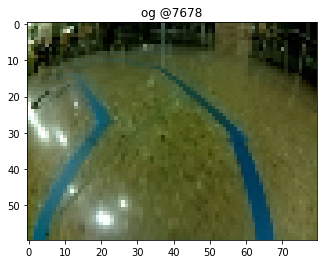

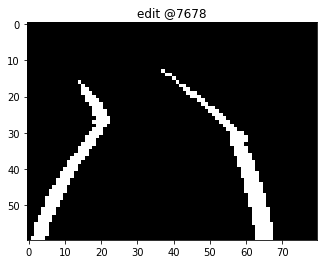

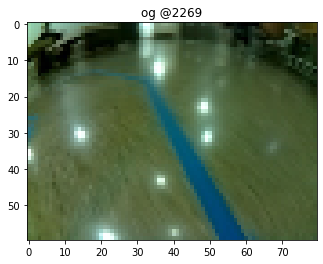

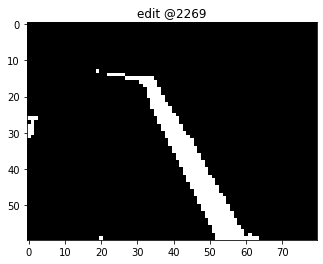

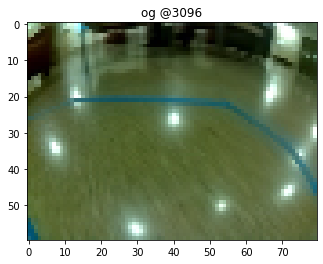

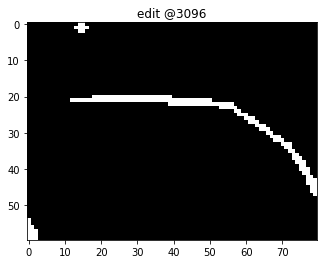

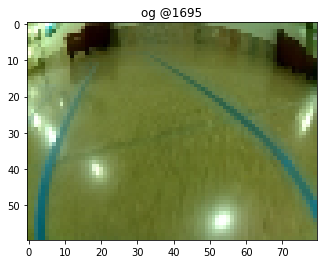

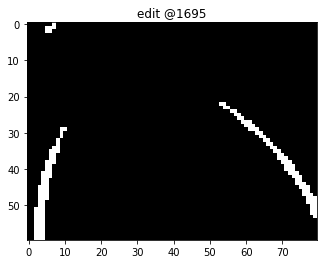

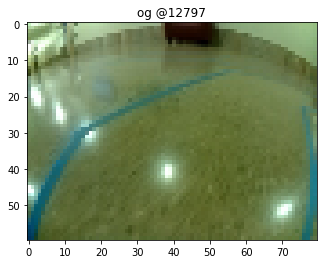

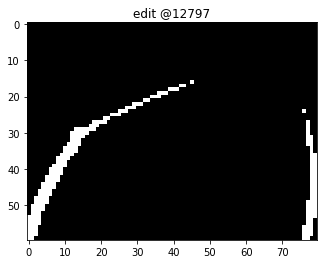

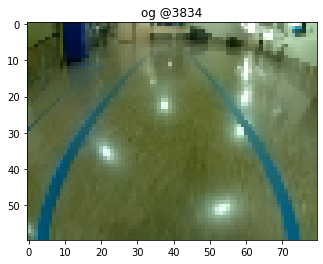

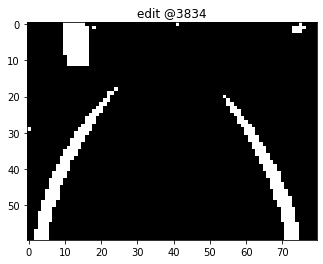

In [158]:
displayRandom(X_test_images, X_test_originals)
displayRandom(X_train_images, X_train_originals)

In [119]:
from sklearn.neighbors import NearestNeighbors
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(imageArray, leftRightArray, test_size=0.5, shuffle=True, random_state=32)

In [12]:
# def classSizeLimitedTraining(X_test, y_test):
#     yLInd = np.where(y_test == left)[0]
#     yRInd = np.where(y_test == right)[0]
#     ySInd = np.where(y_test == straight)[0]
#     classSize = min(len(yLInd), len(yRInd), len(ySInd))
#     np.random.seed(39)
#     cl = np.random.permutation(yLInd)[:classSize]
#     cr = np.random.permutation(yRInd)[:classSize]
#     cs = np.random.permutation(ySInd)[:classSize]
#     y_new = np.concatenate([y_test[cl],y_test[cr],y_test[cs]])
#     X_new = np.concatenate([X_test[cl],X_test[cr],X_test[cs]])
#     return X_new, y_new

In [13]:
# X_s_train, y_s_train = classSizeLimitedTraining(X_train, y_train)
# X_s_test, y_s_test = classSizeLimitedTraining(X_test, y_test)

In [14]:
y_train.shape

(15942,)

In [164]:
X_train[0].shape

(4800,)

# K-NearestNeighbours

In [22]:
from sklearn.neighbors import KNeighborsClassifier

In [11]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics._plot import confusion_matrix as cm
from sklearn.metrics import confusion_matrix

In [18]:
def runKNN(k):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_test)
    acc = accuracy_score(y_test, y_predict)
    bacc = balanced_accuracy_score(y_test, y_predict)
    print(f'k={k} test accuracy: {acc:.3f} bacc: {bacc:.3f}')
    matrix = confusion_matrix(y_test, y_predict)
    disp=cm.ConfusionMatrixDisplay(confusion_matrix=matrix,
                               display_labels=['-1','0','1'])
    disp.plot(include_values=True, cmap=plt.cm.Blues);

In [19]:
for i in range(3,5):
    runKNN(i)
    pass

KeyboardInterrupt: 

# Keras

In [11]:
# X_test, y_test, X_test_images = processedImageSet(test_images, test_labels, processImage)
# X_train, y_train, X_train_images = processedImageSet(train_images, train_labels, processImage)

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [15]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [159]:
from keras import backend as K
K.clear_session()
history1 = None
model = None

In [165]:
model = keras.Sequential(
    [
        keras.Input(shape=(4800,)),
        layers.Dropout(.4),
        layers.Dense(64, activation="relu", name="layer3"),
        layers.Dropout(.4),
        layers.Dense(64, activation="relu", name="layer4"),
#         layers.Dense(480, activation="relu", name="layer1"),
#         layers.Dense(240, activation="relu", name="layer2"),
#         layers.Dense(128, activation="relu", name="layer3"),
#        layers.Dense(24, activation="relu", name="layer4"),
        layers.Dense(3, name="layer6", activation="softmax"),
    ]
)

In [166]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_2 (Dropout)          (None, 4800)              0         
_________________________________________________________________
layer3 (Dense)               (None, 64)                307264    
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
layer4 (Dense)               (None, 64)                4160      
_________________________________________________________________
layer6 (Dense)               (None, 3)                 195       
Total params: 311,619
Trainable params: 311,619
Non-trainable params: 0
_________________________________________________________________


In [167]:
# loss_fn = keras.losses.categorical_crossentropy()
opt = keras.optimizers.SGD(learning_rate=0.005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'mse'])

In [168]:
# Call model on a test input
y = model(X_test)
y

<tf.Tensor: shape=(9434, 3), dtype=float32, numpy=
array([[1.7185305e-15, 1.0000000e+00, 0.0000000e+00],
       [1.7185305e-15, 1.0000000e+00, 0.0000000e+00],
       [2.6461410e-23, 1.0000000e+00, 0.0000000e+00],
       ...,
       [1.0493973e-11, 1.0000000e+00, 0.0000000e+00],
       [9.4269103e-01, 5.7308964e-02, 3.7719586e-13],
       [9.4357604e-01, 5.6423917e-02, 1.5102034e-28]], dtype=float32)>

In [175]:
from sklearn.preprocessing import OneHotEncoder
esc = OneHotEncoder()
esc.fit(np.array([-1,0,1]).reshape(-1, 1))
y_train_os = esc.transform(y_train.reshape(-1,1)).toarray()
y_test_os = esc.transform(y_test.reshape(-1,1)).toarray()
y_val_os = esc.transform(y_val.reshape(-1,1)).toarray()
# es = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto',patience=10)

In [176]:
n_epochs = 20
history1 = model.fit((X_train / 255), y_train_os, validation_data=((X_val / 255), y_val_os), batch_size=32, epochs=n_epochs, verbose=1)

Epoch 1/20
499/499 [==============================] - 2s 5ms/step - loss: 0.2692 - accuracy: 0.8950 - mse: 0.0525 - val_loss: 0.5659 - val_accuracy: 0.8059 - val_mse: 0.0980
Epoch 2/20
499/499 [==============================] - 2s 5ms/step - loss: 0.2647 - accuracy: 0.8954 - mse: 0.0516 - val_loss: 0.5678 - val_accuracy: 0.8047 - val_mse: 0.0982
Epoch 3/20
499/499 [==============================] - 2s 5ms/step - loss: 0.2571 - accuracy: 0.8985 - mse: 0.0500 - val_loss: 0.5729 - val_accuracy: 0.8059 - val_mse: 0.0982
Epoch 4/20
499/499 [==============================] - 2s 5ms/step - loss: 0.2538 - accuracy: 0.8995 - mse: 0.0492 - val_loss: 0.5651 - val_accuracy: 0.8079 - val_mse: 0.0971
Epoch 5/20
499/499 [==============================] - 2s 5ms/step - loss: 0.2509 - accuracy: 0.9013 - mse: 0.0487 - val_loss: 0.5723 - val_accuracy: 0.8066 - val_mse: 0.0978
Epoch 6/20
499/499 [==============================] - 2s 5ms/step - loss: 0.2465 - accuracy: 0.9021 - mse: 0.0480 - val_loss: 0.57

test accuracy: 0.955 bacc: 0.936


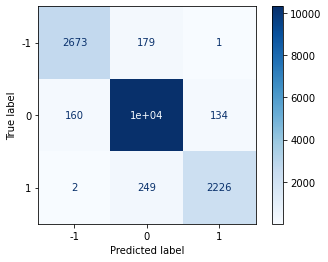

In [177]:
y_train_pred_out = model(np.array([X_train]))
y_train_pred = np.array([raw.numpy().argmax() - 1 for raw in y_train_pred_out[0]])
acc = accuracy_score(y_train, y_train_pred)
bacc = balanced_accuracy_score(y_train, y_train_pred)
print(f'test accuracy: {acc:.3f} bacc: {bacc:.3f}')
matrix = confusion_matrix(y_train, y_train_pred)
disp=cm.ConfusionMatrixDisplay(confusion_matrix=matrix,
                               display_labels=['-1','0','1'])
disp.plot(include_values=True, cmap=plt.cm.Blues);

test accuracy: 0.743 bacc: 0.706


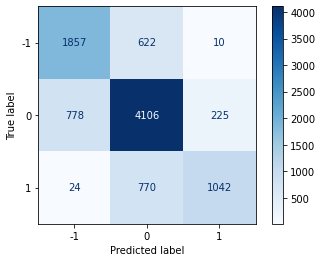

In [178]:
y_test_pred_out = model(np.array([X_test]))
y_test_pred = np.array([raw.numpy().argmax() - 1 for raw in y_test_pred_out[0]])
acc = accuracy_score(y_test, y_test_pred)
bacc = balanced_accuracy_score(y_test, y_test_pred)
print(f'test accuracy: {acc:.3f} bacc: {bacc:.3f}')
matrix = confusion_matrix(y_test, y_test_pred)
disp=cm.ConfusionMatrixDisplay(confusion_matrix=matrix,
                               display_labels=['-1','0','1'])
disp.plot(include_values=True, cmap=plt.cm.Blues);

In [188]:
errors = np.where(y_test_pred != y_test)[0]
i = np.random.choice(errors)
print("pred")
print(y_test_pred[i])
printint("true")
print(y_test[i])
dispIm(X_test_originals[i])
dispIm(X_test_images[i])

pred
0


NameError: name 'printint' is not defined